# Analysis

In [1]:
#imports
import pandas as pd
import matplotlib.pyplot as plt

### Total call proportions

In [2]:
CAD_data = pd.read_csv("data\cleaned_data\cleaned_CAD_data.csv", parse_dates=['Call_Created_Time'])
cahoots_dataset = pd.read_csv("data\cleaned_data\cleaned_Cahoots_data.csv", parse_dates=['DateTime'])
CAD_data_diversions = pd.read_csv("data\cleaned_data\cleaned_CAD_diversions.csv", parse_dates=['Call_Created_Time'])

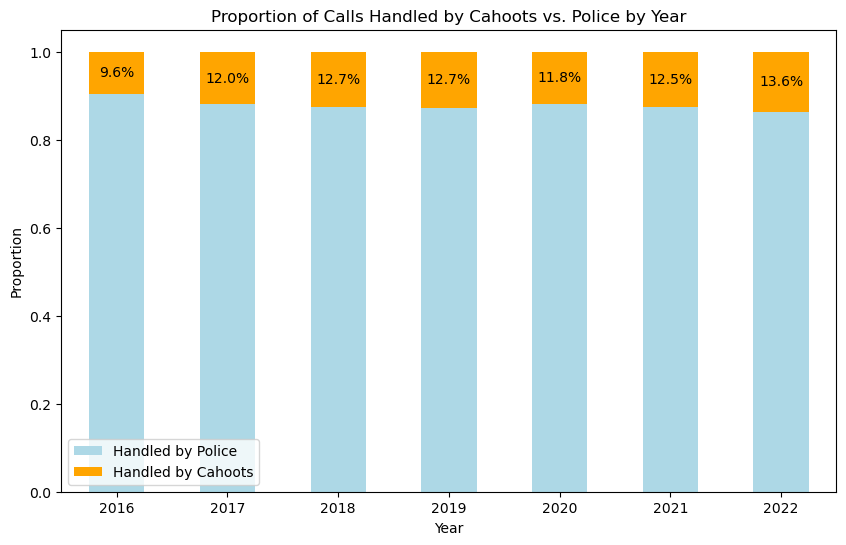

In [66]:
# Group by year and 'Handled_by_Cahoots' and calculate proportions

yearly_data = CAD_data.groupby([CAD_data['Call_Created_Time'].dt.year, 'Handled_by_Cahoots']).size().unstack(fill_value=0)
yearly_data_prop = yearly_data.div(yearly_data.sum(axis=1), axis=0)

# Update proportions for 2021 and 2022 with data from cahoots_dataset
cahoots_counts = cahoots_dataset[cahoots_dataset['DateTime'].dt.year.isin([2021, 2022])].groupby(cahoots_dataset['DateTime'].dt.year).size()
yearly_data.loc[2021, 1] = cahoots_counts.get(2021, 0)  # get() ensures no error if the year isn't present
yearly_data.loc[2022, 1] = cahoots_counts.get(2022, 0)
yearly_data_prop = yearly_data.div(yearly_data.sum(axis=1), axis=0)

ax = yearly_data_prop.plot(kind='bar', stacked=True, color=['lightblue', 'orange'], figsize=(10, 6))

# Add labels to the Cahoots portion of the bars
for i in range(yearly_data_prop.shape[0]):  # Loop over years
    cahoots_proportion = yearly_data_prop.iloc[i, 1]  # Proportion handled by Cahoots
    if cahoots_proportion > 0:  # Only label non-zero bars
        ax.text(i, yearly_data_prop.iloc[i, 0] + cahoots_proportion / 2,
                f'{cahoots_proportion:.1%}', ha='center', va='center', fontsize=10, color='black')

# Plot settings
plt.title('Proportion of Calls Handled by Cahoots vs. Police by Year')
plt.xlabel('Year')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.legend(['Handled by Police', 'Handled by Cahoots'], loc='lower left')
plt.show()

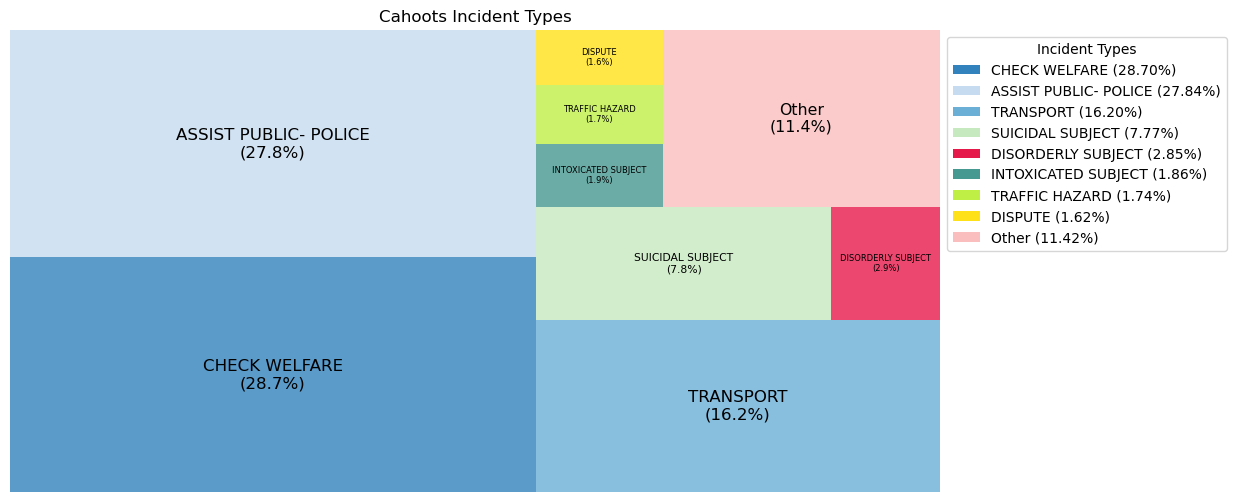

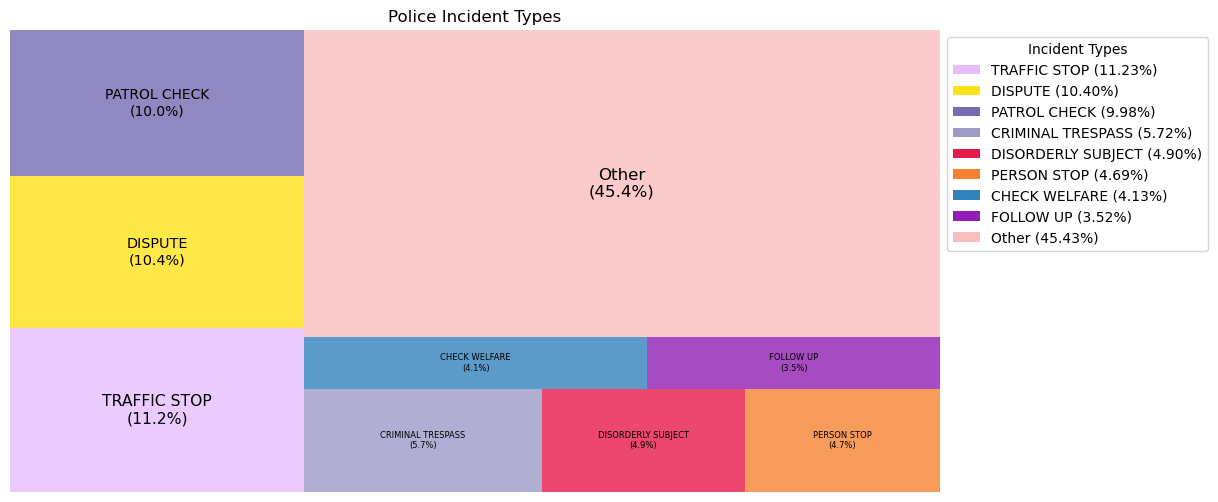

In [67]:
import matplotlib.pyplot as plt
import squarify
import numpy as np
import pandas as pd
import hashlib

target = 'InitialIncidentTypeDescription'

def process_data(data, top_n, group_others, target):
    value_counts = data[target].value_counts()
    total = value_counts.sum()
    if group_others:
        top_categories = value_counts.nlargest(top_n)
        other_sum = value_counts.iloc[top_n:].sum()
        if other_sum > 0:
            top_categories['Other'] = other_sum
    else:
        top_categories = value_counts.nlargest(top_n)
    return top_categories, total

def hash_to_index(text, num_colors):
    # Generate a hash for the text and map it to an index
    hash_val = int(hashlib.sha256(text.encode('utf-8')).hexdigest(), 16)
    return hash_val % num_colors

def create_treemap(data, title, top_n, group_others, max_legend_entries, show_labels, color_list):
    num_colors = len(color_list)
    top_data, total = process_data(data, top_n, group_others, target)
    
    color_map = {}
    assigned_colors = set()
    for label in top_data.index:
        index = hash_to_index(label, num_colors)
        original_index = index  
        while color_list[index] in assigned_colors:
            index = (index + 1) % num_colors
            if index == original_index:
                break  
        color_map[label] = color_list[index]
        assigned_colors.add(color_list[index])
    
    if 'Other' not in color_map:
        color_map['Other'] = '#CCCCCC'  
    
    fig, ax = plt.subplots(figsize=(12, 6))
    sizes = top_data.values
    colors = [color_map[label] if label in color_map else '#CCCCCC' for label in top_data.index]  # Default color for 'Other'
    labels = [f"{incident}\n({value / total * 100:.1f}%)" if show_labels else "" for incident, value in top_data.items()]
    
    squarify.plot(sizes=sizes, label=labels, color=colors, alpha=0.8, pad=False, text_kwargs={'fontsize': 'smaller'})
    plt.title(title)
    plt.axis('off')

    # Adjust text size based on the area of the boxes
    if show_labels:
        total_area = sum([rect.get_width() * rect.get_height() for rect in ax.patches])
        for text, rect in zip(ax.texts, ax.patches):
            # Adjust font size based on box area
            area_ratio = (rect.get_width() * rect.get_height()) / total_area
            font_size = max(6, min(12, area_ratio * total_area / 100))  # Scale font size between 6 and 12
            text.set_fontsize(font_size)

    # legend
    patches = [plt.Rectangle((0, 0), 1, 1, facecolor=color_map[incident]) for incident in top_data.index]
    legend_labels = [f"{incident} ({value / total * 100:.2f}%)" for incident, value in top_data.items()]
    plt.legend(patches, legend_labels[:max_legend_entries], loc='upper left', bbox_to_anchor=(1, 1), title="Incident Types")

    plt.show()

color_list = [
    '#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231',
    '#911eb4', '#42d4f4', '#f032e6', '#bfef45', '#fabebe',
    '#469990', '#e6beff', '#9a6324', '#fffac8', '#800000',
    '#3182bd', '#6baed6', '#9ecae1', '#c6dbef', '#e6550d',
    '#fd8d3c', '#fdae6b', '#fdd0a2', '#31a354', '#74c476',
    '#a1d99b', '#c7e9c0', '#756bb1', '#9e9ac8', '#bcbddc'
]


cahoots_data = CAD_data[CAD_data['Handled_by_Cahoots'] == 1]
police_data = CAD_data[CAD_data['Handled_by_Cahoots'] == 0]

create_treemap(cahoots_data, 'Cahoots Incident Types', top_n=8, group_others=True, max_legend_entries=10, show_labels=True, color_list=color_list)
create_treemap(police_data, 'Police Incident Types', top_n=8, group_others=True, max_legend_entries=10, show_labels=True, color_list=color_list)

### Visualizing Diversions

In [68]:
cahoots_dataset_diversions = cahoots_dataset[~(cahoots_dataset["Reason for Dispatch"].isin(["Transport", "Counseling"]))]
CAD_data_diversions_filtered = CAD_data_diversions[~(CAD_data_diversions["Disposition"].isin(["ARREST", "TRANSPORT MADE"]))]
CAD_data_diversions_filtered = CAD_data_diversions_filtered[~(CAD_data_diversions_filtered["InitialIncidentTypeDescription"].isin(["TRANSPORT"]))]


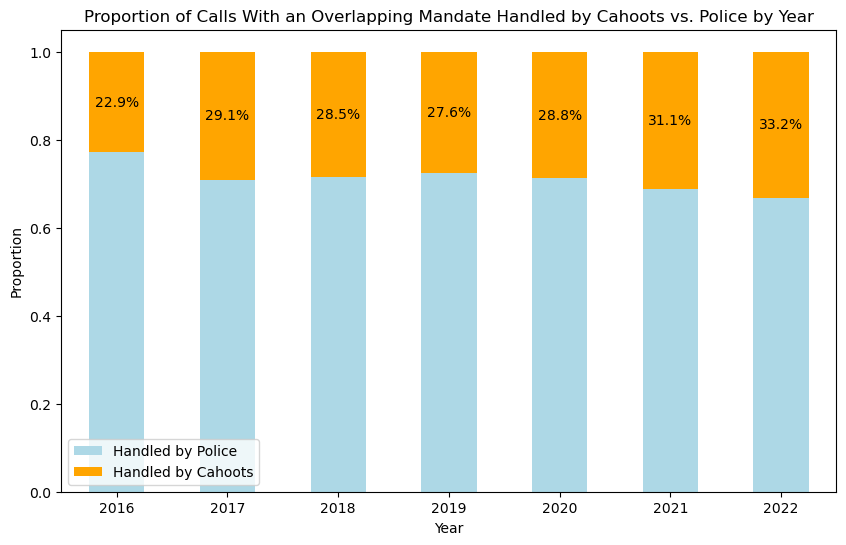

In [69]:
yearly_data_diversions = CAD_data_diversions_filtered.groupby([CAD_data_diversions_filtered['Call_Created_Time'].dt.year, 'Handled_by_Cahoots']).size().unstack(fill_value=0)

cahoots_counts_diversions = cahoots_dataset_diversions[cahoots_dataset_diversions['DateTime'].dt.year.isin([2021, 2022])].groupby(cahoots_dataset_diversions['DateTime'].dt.year).size()
yearly_data_diversions.loc[2021, 1] = cahoots_counts_diversions.get(2021, 0) 
yearly_data_diversions.loc[2022, 1] = cahoots_counts_diversions.get(2022, 0)
yearly_data_prop_diversions = yearly_data_diversions.div(yearly_data_diversions.sum(axis=1), axis=0)

ax = yearly_data_prop_diversions.plot(kind='bar', stacked=True, color=['lightblue', 'orange'], figsize=(10, 6))

# Add labels 
for i in range(yearly_data_prop_diversions.shape[0]):  
    cahoots_proportion = yearly_data_prop_diversions.iloc[i, 1]  # Proportion handled by Cahoots
    if cahoots_proportion > 0:  
        ax.text(i, yearly_data_prop_diversions.iloc[i, 0] + cahoots_proportion / 2,
                f'{cahoots_proportion:.1%}', ha='center', va='center', fontsize=10, color='black')

# Plot settings
plt.title('Proportion of Calls With an Overlapping Mandate Handled by Cahoots vs. Police by Year')
plt.xlabel('Year')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.legend(['Handled by Police', 'Handled by Cahoots'], loc='lower left')

plt.show()

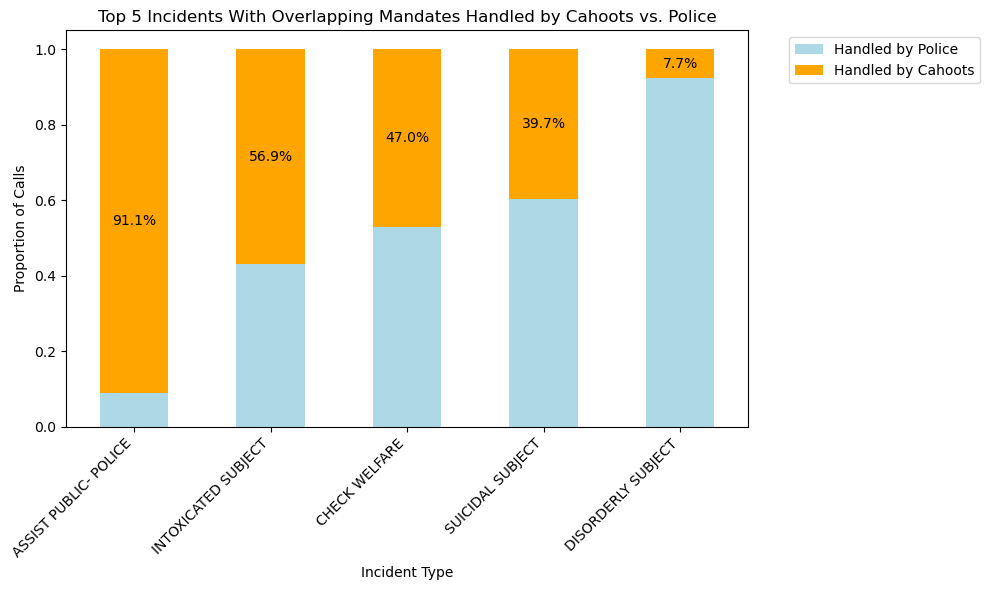

In [70]:
top_5_incidents = CAD_data_diversions_filtered[CAD_data_diversions_filtered["Handled_by_Cahoots"] == 1]["InitialIncidentTypeDescription"].value_counts().nlargest(5).index

CAD_data_diversions_filtered_top_5 = CAD_data_diversions_filtered[CAD_data_diversions_filtered["InitialIncidentTypeDescription"].isin(top_5_incidents)]

incident_data = CAD_data_diversions_filtered_top_5.groupby(['InitialIncidentTypeDescription', 'Handled_by_Cahoots']).size().unstack(fill_value=0)
incident_data_prop = incident_data.div(incident_data.sum(axis=1), axis=0)

incident_data_sorted = incident_data_prop.sort_values(by=1, ascending=False)
ax = incident_data_sorted.plot(kind='bar', stacked=True, color=['lightblue', 'orange'], figsize=(10, 6))

# Add labels to the Cahoots portion of the bars
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if p.get_facecolor() == ax.patches[-1].get_facecolor() and height > 0: 
        ax.text(x + width / 2, y + height / 2, f'{height:.1%}', ha='center', va='center', fontsize=10)

plt.title('Top 5 Incidents With Overlapping Mandates Handled by Cahoots vs. Police')
plt.xlabel('Incident Type')
plt.ylabel('Proportion of Calls')
plt.xticks(rotation=45, ha='right')
plt.legend(['Handled by Police', 'Handled by Cahoots'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

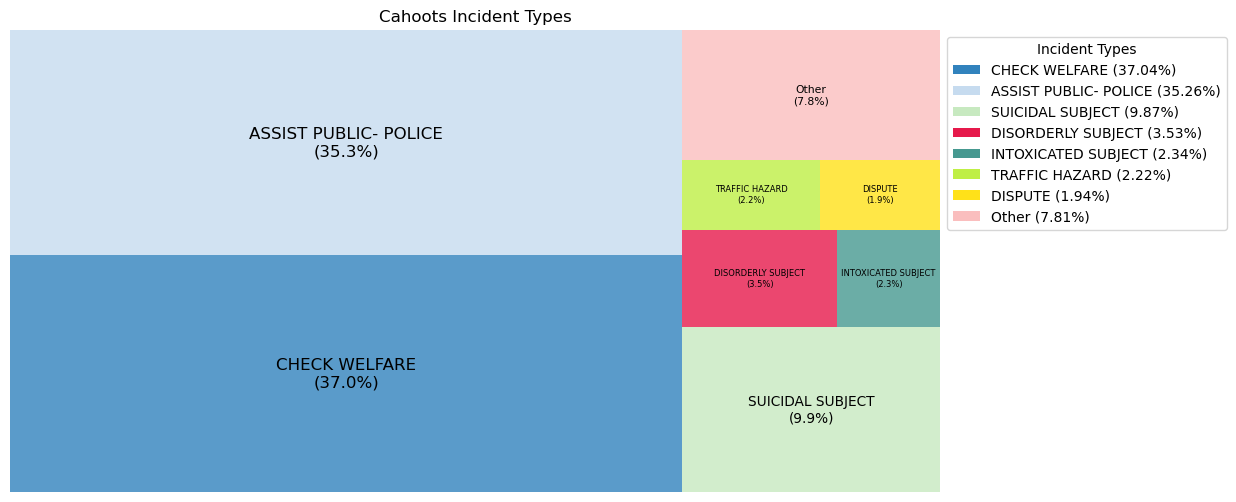

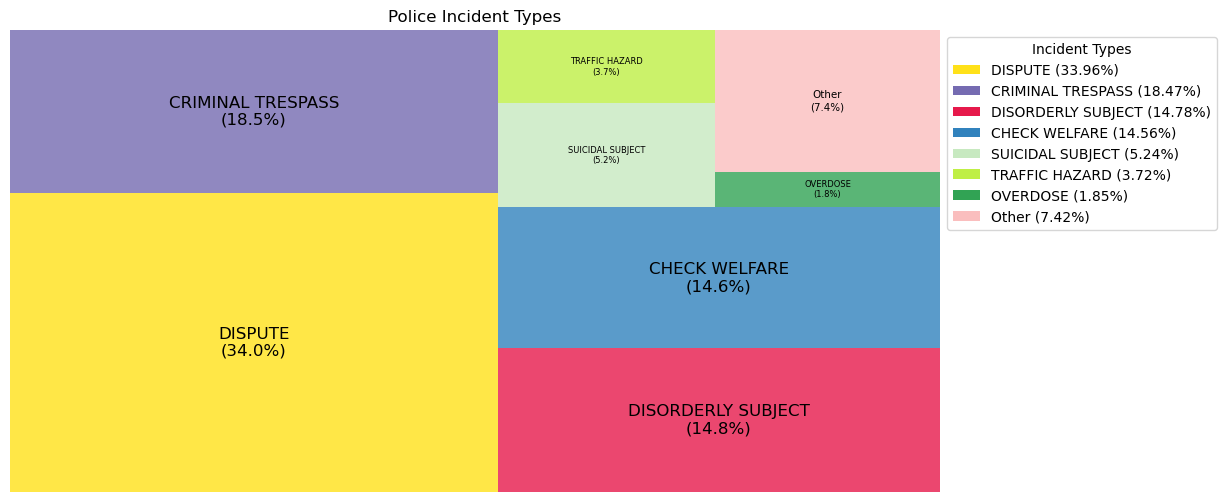

In [71]:
create_treemap(CAD_data_diversions_filtered[CAD_data_diversions_filtered["Handled_by_Cahoots"] == 1], 'Cahoots Incident Types', top_n=7, group_others=True, max_legend_entries=10, show_labels=True, color_list=color_list)
create_treemap(CAD_data_diversions_filtered[CAD_data_diversions_filtered["Handled_by_Cahoots"] == 0], 'Police Incident Types', top_n=7, group_others=True, max_legend_entries=10, show_labels=True, color_list=color_list)

C:\Users\Nathan Burton\AppData\Local\Temp\ipykernel_12260\728564545.py:33: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


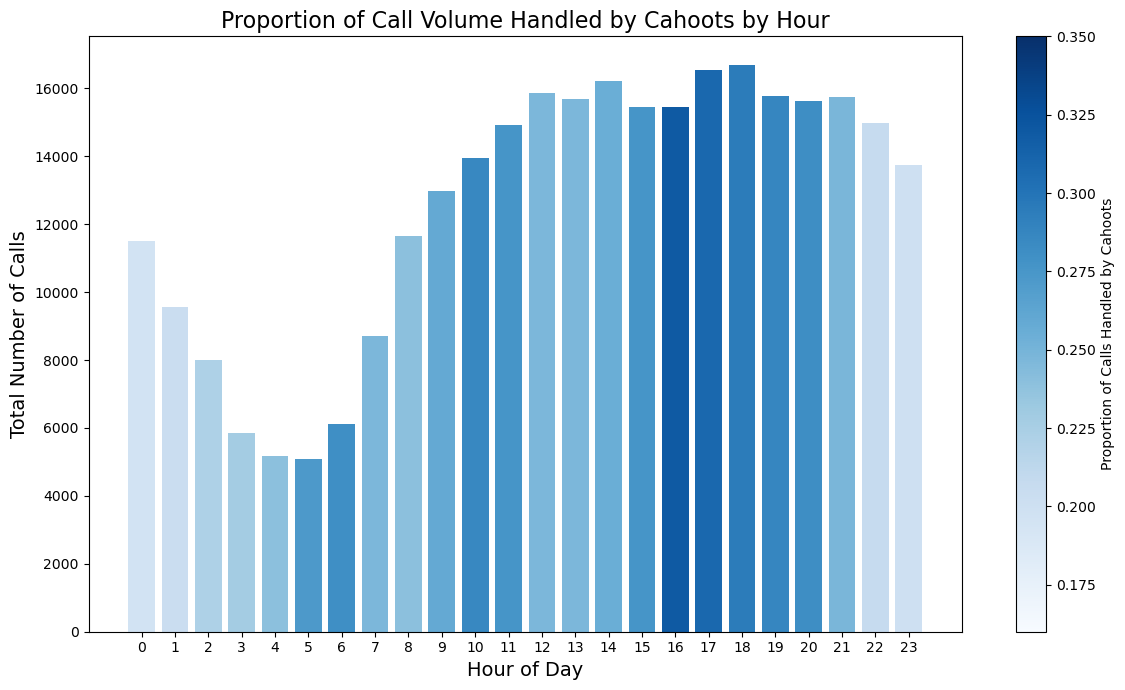

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure 'Call_Created_Time' is in datetime format
CAD_data_diversions_filtered['Call_Created_Time'] = pd.to_datetime(CAD_data_diversions_filtered['Call_Created_Time'])

# Extract the hour from 'Call_Created_Time'
CAD_data_diversions_filtered['Hour'] = CAD_data_diversions_filtered['Call_Created_Time'].dt.hour

# Calculate the number of calls handled by police and Cahoots by hour
call_volume_by_hour = CAD_data_diversions_filtered.groupby(['Hour', 'Handled_by_Cahoots']).size().unstack(fill_value=0)
call_volume_by_hour.columns = ['Police', 'Cahoots']

# Calculate the proportions
call_volume_by_hour['Total'] = call_volume_by_hour.sum(axis=1)
call_volume_by_hour['Cahoots_Proportion'] = call_volume_by_hour['Cahoots'] / call_volume_by_hour['Total']
call_volume_by_hour['Police_Proportion'] = call_volume_by_hour['Police'] / call_volume_by_hour['Total']

# Plot the bar chart with improved color intensity
plt.figure(figsize=(12, 7))

# Normalize the Cahoots proportions to [0, 1] range for color mapping
norm = plt.Normalize(0.16, .35)
colors = plt.cm.Blues(norm(call_volume_by_hour['Cahoots_Proportion']))

bars = plt.bar(call_volume_by_hour.index, call_volume_by_hour['Total'], color=colors)

# Add color bar for reference
sm = plt.cm.ScalarMappable(cmap="Blues", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Proportion of Calls Handled by Cahoots')

# Add labels, title, and customize the plot
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Total Number of Calls', fontsize=14)
plt.title('Proportion of Call Volume Handled by Cahoots by Hour', fontsize=16)
plt.xticks(range(0, 24))
plt.tight_layout()

# Display the plot
plt.show()


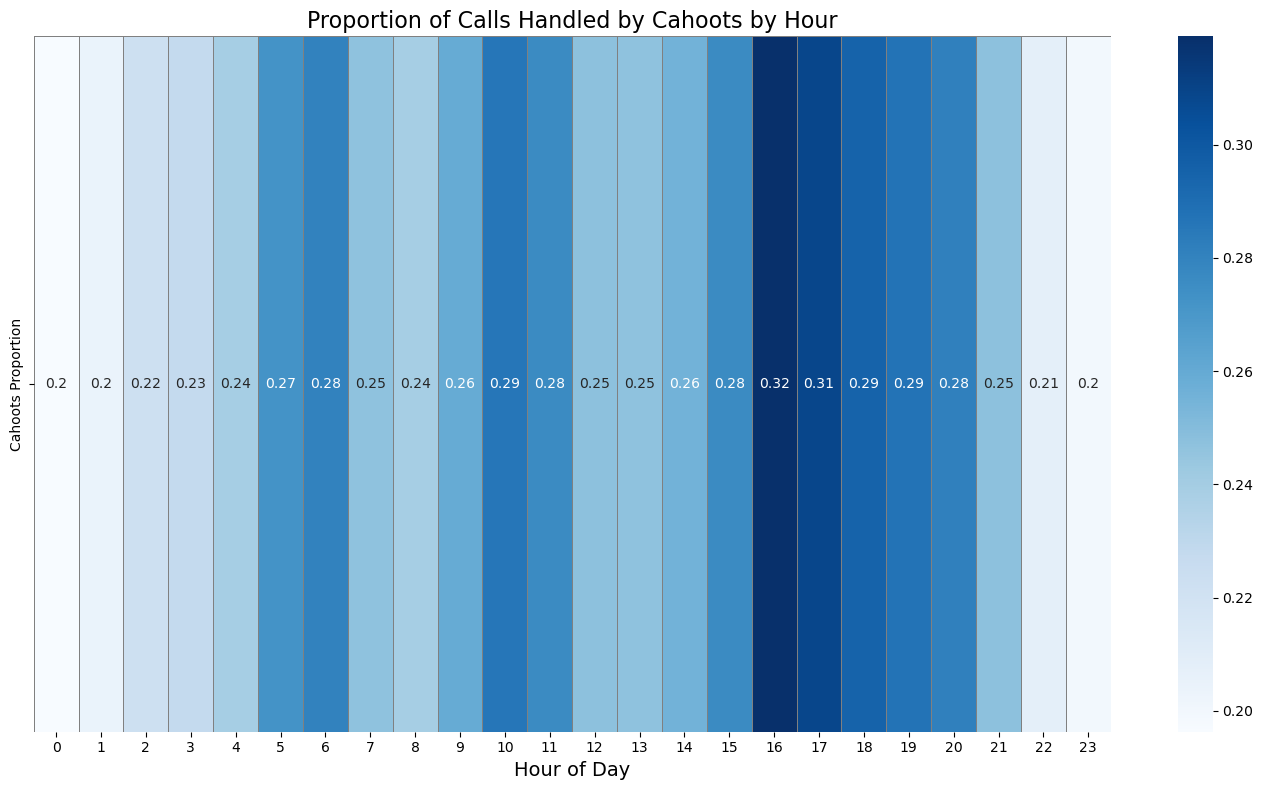

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'Call_Created_Time' is in datetime format
CAD_data_diversions_filtered['Call_Created_Time'] = pd.to_datetime(CAD_data_diversions_filtered['Call_Created_Time'])

# Extract the hour from 'Call_Created_Time'
CAD_data_diversions_filtered['Hour'] = CAD_data_diversions_filtered['Call_Created_Time'].dt.hour

# Calculate the proportion of calls handled by Cahoots by hour
call_volume_by_hour = CAD_data_diversions_filtered.groupby(['Hour', 'Handled_by_Cahoots']).size().unstack(fill_value=0)
call_volume_by_hour.columns = ['Police', 'Cahoots']
call_volume_by_hour['Total'] = call_volume_by_hour.sum(axis=1)
call_volume_by_hour['Cahoots_Proportion'] = call_volume_by_hour['Cahoots'] / call_volume_by_hour['Total']

# Create a heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(call_volume_by_hour[['Cahoots_Proportion']].T, cmap='Blues', annot=True, cbar=True, xticklabels=range(24), yticklabels=['Cahoots Proportion'], linewidths=0.5, linecolor='gray')

# Add labels and title
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('', fontsize=14)  # Y-axis label is not needed for this single-row heatmap
plt.title('Proportion of Calls Handled by Cahoots by Hour', fontsize=16)

# Display the plot
plt.tight_layout()
plt.show()


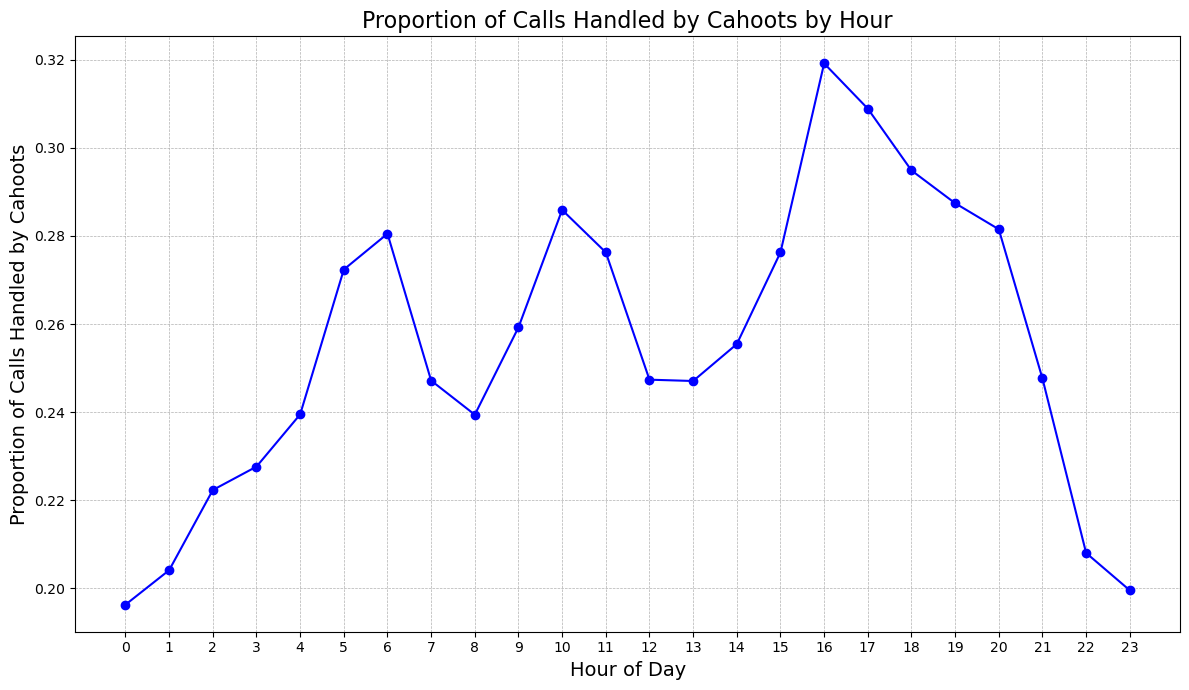

In [74]:
# Create a line plot
plt.figure(figsize=(12, 7))
plt.plot(call_volume_by_hour.index, call_volume_by_hour['Cahoots_Proportion'], marker='o', linestyle='-', color='blue')

# Add labels, title, and customize the plot
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Proportion of Calls Handled by Cahoots', fontsize=14)
plt.title('Proportion of Calls Handled by Cahoots by Hour', fontsize=16)
plt.xticks(range(0, 24))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()


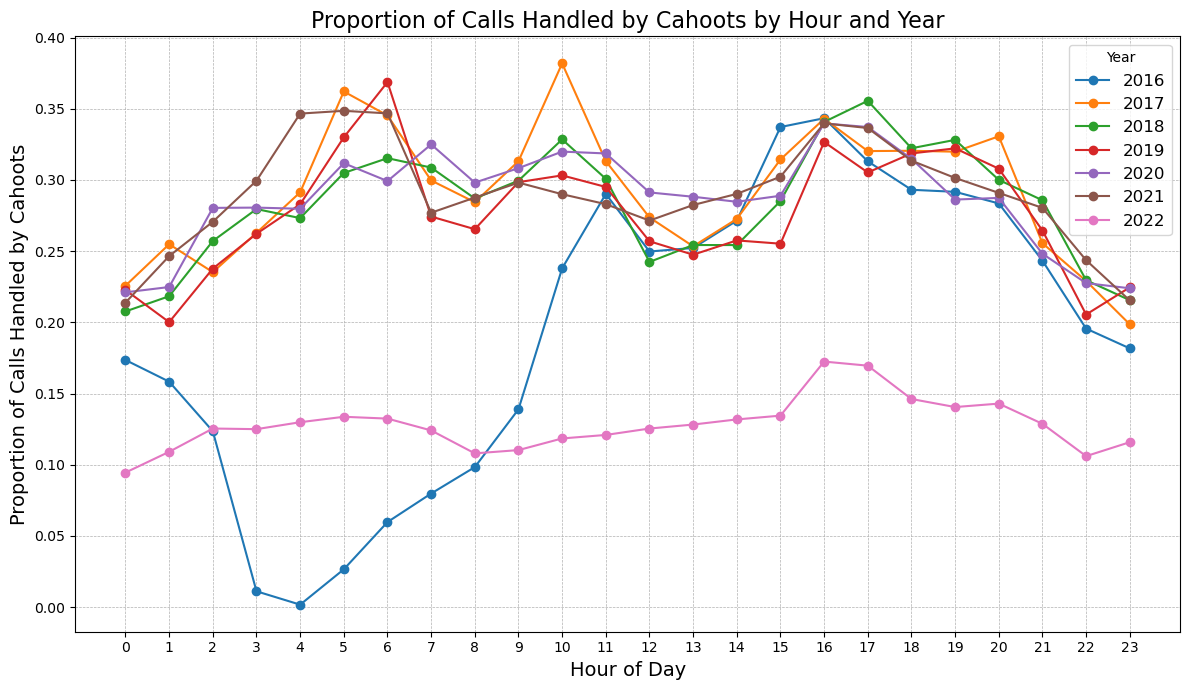

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'Call_Created_Time' is in datetime format
CAD_data_diversions_filtered['Call_Created_Time'] = pd.to_datetime(CAD_data_diversions_filtered['Call_Created_Time'])

# Extract the hour and year from 'Call_Created_Time'
CAD_data_diversions_filtered['Hour'] = CAD_data_diversions_filtered['Call_Created_Time'].dt.hour
CAD_data_diversions_filtered['Year'] = CAD_data_diversions_filtered['Call_Created_Time'].dt.year

# Calculate the proportion of calls handled by Cahoots by hour for each year
call_volume_by_hour_year = CAD_data_diversions_filtered.groupby(['Year', 'Hour', 'Handled_by_Cahoots']).size().unstack(fill_value=0)
call_volume_by_hour_year.columns = ['Police', 'Cahoots']
call_volume_by_hour_year['Total'] = call_volume_by_hour_year.sum(axis=1)
call_volume_by_hour_year['Cahoots_Proportion'] = call_volume_by_hour_year['Cahoots'] / call_volume_by_hour_year['Total']

# Plot the line plot with a new line for each year
plt.figure(figsize=(12, 7))

for year in call_volume_by_hour_year.index.get_level_values('Year').unique():
    data = call_volume_by_hour_year.xs(year, level='Year')
    plt.plot(data.index, data['Cahoots_Proportion'], marker='o', linestyle='-', label=str(year))

# Add labels, title, and customize the plot
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Proportion of Calls Handled by Cahoots', fontsize=14)
plt.title('Proportion of Calls Handled by Cahoots by Hour and Year', fontsize=16)
plt.xticks(range(0, 24))
plt.legend(title='Year', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()

<Figure size 1200x700 with 0 Axes>

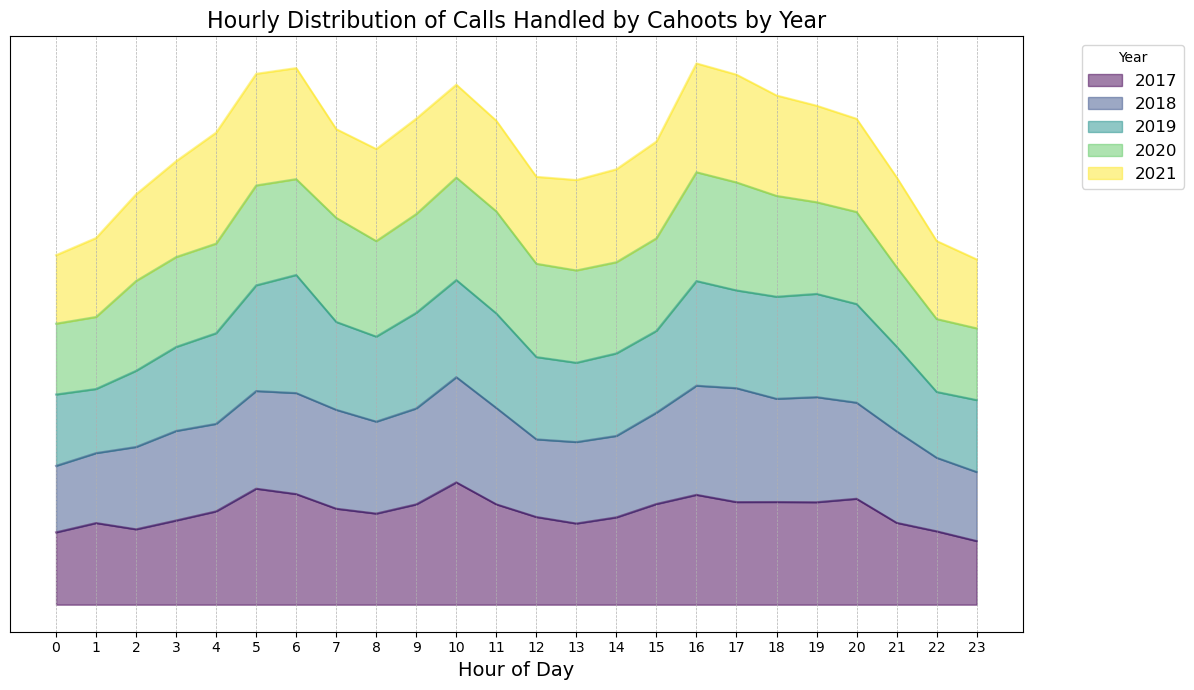

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'Call_Created_Time' is in datetime format
CAD_data_diversions_filtered['Call_Created_Time'] = pd.to_datetime(CAD_data_diversions_filtered['Call_Created_Time'])

# Extract the hour and year from 'Call_Created_Time'
CAD_data_diversions_filtered['Hour'] = CAD_data_diversions_filtered['Call_Created_Time'].dt.hour
CAD_data_diversions_filtered['Year'] = CAD_data_diversions_filtered['Call_Created_Time'].dt.year

# Filter out the years 2016 and 2022
filtered_data = CAD_data_diversions_filtered[~CAD_data_diversions_filtered['Year'].isin([2016, 2022])]

# Calculate the proportion of calls handled by Cahoots by hour for each year
call_volume_by_hour_year = filtered_data.groupby(['Year', 'Hour', 'Handled_by_Cahoots']).size().unstack(fill_value=0)
call_volume_by_hour_year.columns = ['Police', 'Cahoots']
call_volume_by_hour_year['Total'] = call_volume_by_hour_year.sum(axis=1)
call_volume_by_hour_year['Cahoots_Proportion'] = call_volume_by_hour_year['Cahoots'] / call_volume_by_hour_year['Total']

# Prepare the data for area plot
call_volume_by_hour_year = call_volume_by_hour_year.reset_index()

# Pivot the data to get a suitable format for area plot
pivot_data = call_volume_by_hour_year.pivot(index='Hour', columns='Year', values='Cahoots_Proportion')

# Plot the area plot
plt.figure(figsize=(12, 7))

pivot_data.plot(kind='area', alpha=0.5, figsize=(12, 7), colormap='viridis')

# Add labels, title, and customize the plot
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('', fontsize=14)
plt.yticks([])
plt.title('Hourly Distribution of Calls Handled by Cahoots by Year', fontsize=16)
plt.legend(title='Year', fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(range(0, 24))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()



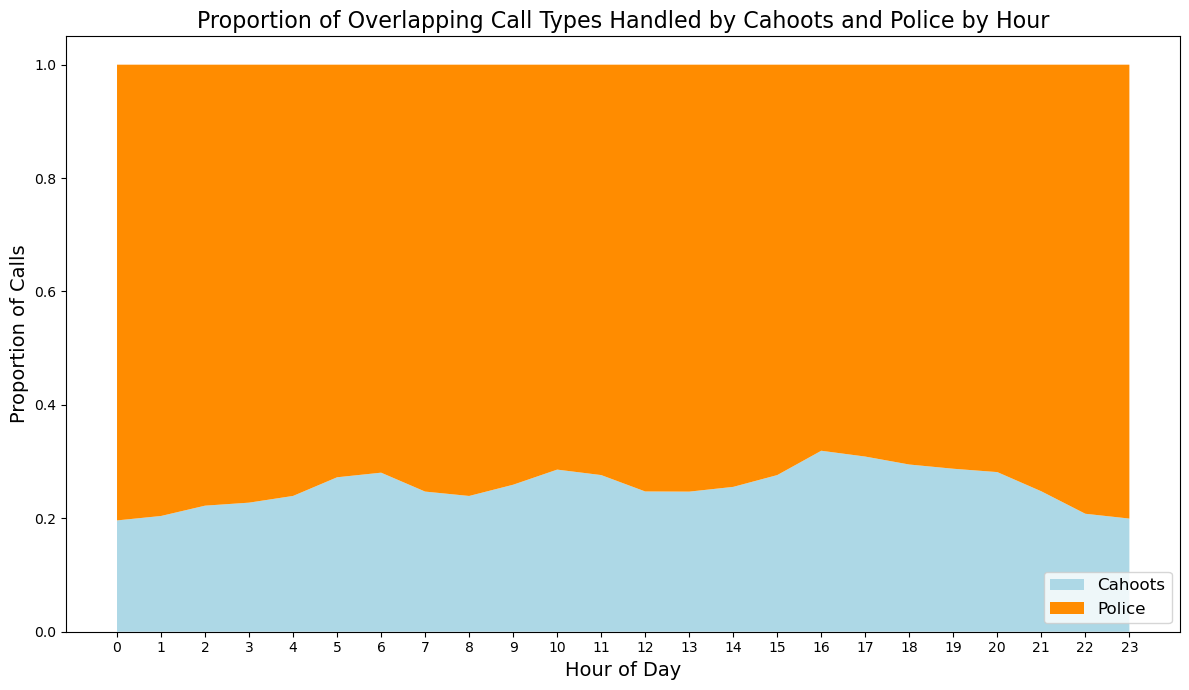

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'Call_Created_Time' is in datetime format
CAD_data_diversions_filtered['Call_Created_Time'] = pd.to_datetime(CAD_data_diversions_filtered['Call_Created_Time'])

# Extract the hour from 'Call_Created_Time'
CAD_data_diversions_filtered['Hour'] = CAD_data_diversions_filtered['Call_Created_Time'].dt.hour

# Calculate the proportion of calls handled by Police and Cahoots by hour
call_volume_by_hour = CAD_data_diversions_filtered.groupby(['Hour', 'Handled_by_Cahoots']).size().unstack(fill_value=0)
call_volume_by_hour.columns = ['Police', 'Cahoots']
call_volume_by_hour['Total'] = call_volume_by_hour.sum(axis=1)
call_volume_by_hour['Police_Proportion'] = call_volume_by_hour['Police'] / call_volume_by_hour['Total']
call_volume_by_hour['Cahoots_Proportion'] = call_volume_by_hour['Cahoots'] / call_volume_by_hour['Total']

# Create an area plot
plt.figure(figsize=(12, 7))
plt.stackplot(call_volume_by_hour.index, call_volume_by_hour['Cahoots_Proportion'], call_volume_by_hour['Police_Proportion'], labels=['Cahoots', 'Police'], colors=['lightblue', 'darkorange'], alpha=1)

# Add labels, title, and customize the plot
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Proportion of Calls', fontsize=14)
plt.title('Proportion of Overlapping Call Types Handled by Cahoots and Police by Hour', fontsize=16)
plt.xticks(range(0, 24))
plt.legend(loc='lower right', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()


In [87]:
CAD_data_diversions_filtered["Disposition"].value_counts()

Disposition
ASSISTED                           85826
ADVISED                            56660
GONE ON ARRIVAL                    35284
UNABLE TO LOCATE                   27898
REPORT TAKEN                       27239
PATROL CHECK                       22779
WELFARE CHECK DONE                 16028
FIELD INVESTIGATION                 6339
CITED IN LIEU OF CUSTODY            5351
WARNING                             4330
NON CRIMINAL HOLD                   3744
UNFOUNDED                           2506
INFORMATION ONLY                    1835
CIVIL ISSUE                         1628
NO INVESTIGATION                    1124
QUIET ON ARRIVAL                     932
FOLLOW UP INVESTIGATION              503
UNHOUSED RELATED ISSUE               360
ASSISTING OFFICER                    234
UNIFORM TRAFFIC CITATION ISSUED      189
SOBRIETY CHECK                       129
PARKING CITATION ISSUED               81
FALSE ALARM                           72
JUVENILE TAKEN INTO CUSTODY           62
PATI